In [1]:
%%bash
#pip install -e /home/jovyan/Tools/dea_tools
pip install ephem
pip install --index-url https://packages.dea.ga.gov.au/ wofs

Looking in indexes: https://packages.dea.ga.gov.au/


In [2]:
import csv
from pathlib import Path
import warnings

import datacube
import geopandas as gpd
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import rasterio
import rioxarray
import scipy.optimize as opt

import sys
sys.path.insert(1, "../Tools/")
from dea_tools.waterbodies import get_time_series, get_waterbody
from dea_tools.spatial import xr_rasterize
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb
from dea_tools import filters

import wofs.wofls
from wofs import classifier, filters
import rioxarray

In [3]:
# Set up the datacube:
dc = datacube.Datacube(app="WaterbodyTimeSeriesS2")

In [4]:
geohash = "r4m0nb230_v3" # Lake Menindee
#ts_sa = get_time_series(geohash=geohash)

In [5]:
# Load the waterbody shape:
shape = get_waterbody(geohash)

time_period = ("2015-08-01", "2017-01-01")

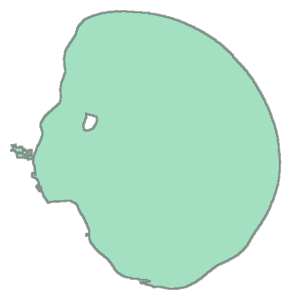

In [6]:
shape.geometry[0]

In [ ]:
ds = load_ard(
    dc,
    products=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    resolution=(-10, 10),
    output_crs="EPSG:3577",
    min_gooddata=0.9,
    geopolygon=datacube.utils.geometry.Geometry(
        shape.geometry[0].buffer(100), crs="EPSG:3577"
    ),
    time=time_period,
)

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 16 out of 32 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 16 time steps


In [ ]:
rgb(ds.isel(time=-1))

## Run WOfS

In [ ]:
# Open the DEM, which is in EPSG:3577
dem = rioxarray.open_rasterio("Menindee.tif")
nodata = dem.rio.nodata


In [ ]:
# Screen out no-data
print("nodata:")
print(f"- rioxarray.open_rasterio: {dem.rio.nodata}")

In [ ]:
dem = dem.where(dem != nodata)

In [ ]:
# Set zero pixels (water) to the minimum to avoid edge effects in WOfS terrain shadows
dem.isel(band=0).values[(dem == 0).values[0]] = dem.where(dem > 0).min()

In [ ]:
# Convert into an xarray dataset for WOfS
dem = xr.Dataset({"elevation": dem.isel(band=0)})

In [ ]:
# Set nodata attrs
ds.attrs["nodata"] = np.nan
for band in ds.variables:
    ds[band].attrs["nodata"] = np.nan

In [ ]:
# and the CRS
dem.attrs["crs"] = "EPSG:3577"

In [ ]:
transform, width, height = rasterio.warp.calculate_default_transform(
    "EPSG:3577", "EPSG:3577", dem.rio.width, dem.rio.height, *dem.rio.bounds()
)

In [ ]:
dem_reproj = rasterio.warp.reproject(
    source=dem.elevation,
    src_transform=dem.rio.transform(),
    src_crs=dem.crs,
    destination=ds.rename({"nbart_blue": "elevation"}).elevation.isel(time=0).copy(),
    dst_transform=ds.rio.transform(),
    dst_crs=ds.crs,
    resampling=rasterio.warp.Resampling.bilinear,
)[0]

In [ ]:
fmask = ds.oa_fmask
print(fmask)
shape = fmask.shape
print(shape)

In [ ]:
from wofs.constants import MASKED_CLOUD, MASKED_CLOUD_SHADOW, NO_DATA

In [ ]:
def fmask_filter(fmask):
    masking = np.zeros(fmask.shape, dtype=np.uint8)
    masking[fmask == 0] += NO_DATA
    masking[fmask == 2] += MASKED_CLOUD
    masking[fmask == 3] += MASKED_CLOUD_SHADOW
    
    return masking

In [ ]:
def spectral_bands(ds):
    bands = [
        "nbart_blue",
        "nbart_green",
        "nbart_red",
        "nbart_nir_1",
        "nbart_nir_2",
        "nbart_swir_2",
        "nbart_swir_3",
    ]
    return ds[bands].to_array(dim="band")

In [ ]:
ard = ds
#print(ard)

In [ ]:
import numpy
import logging
import gc

try:
    import dask.array
    dask_array_type = (dask.array.Array,)
except ImportError:  # pragma: no cover
    dask_array_type = ()

from wofs import boilerplate


In [ ]:
test = ds.isel(time=0)
ard = test

In [ ]:
nbart_bands = spectral_bands(ard)
print(nbart_bands)

In [ ]:
water = classifier.classify(nbart_bands) \
    | eo_filter(ard) \
    | fmask_filter(ard.fmask)

In [ ]:
def woffles_ard(ard, dsm, dsm_no_data=-1000, ignore_dsm_no_data=False):
    """Generate a Water Observation Feature Layer from ARD (NBART and FMASK) and surface elevation inputs."""
    nbar_bands = spectral_bands(ard)
    water = classifier.classify(nbar_bands) \
        | eo_filter(ard) \
        | fmask_filter(ard.fmask)

    if dsm is not None:
        # terrain_filter arbitrarily expects a band named 'blue'
        water |= terrain_filter(
            dsm,
            ard.rename({"nbart_blue": "blue"}),
            no_data=dsm_no_data,
            ignore_dsm_no_data=ignore_dsm_no_data
        )

    _fix_nodata_to_single_value(water)

    assert water.dtype == np.uint8

    return water

In [ ]:
s2_wofls = []
for i in tqdm(range(len(ds.time))):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s2_wofls_ = wofs.wofls.woffles_ard(
            ds.rename(
                {
                    "nbart_nir_1": "nbart_nir",
                    "nbart_swir_2": "nbart_swir_1",
                    "nbart_swir_3": "nbart_swir_2",
                }
            ).isel(time=i),
            xr.Dataset({"elevation": dem_reproj}, attrs={"crs": "EPSG:3577"}),
        )
        s2_wofls.append(s2_wofls_)